### MODELO RANDOM FOREST

# Rubén Cobarro Martínez y Javier Serrat

# Importación de librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import scipy.stats as ss
import warnings
import category_encoders as ce
from category_encoders.target_encoder import TargetEncoder
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt 

from sklearn.metrics import classification_report

import pickle 

# Lectura del CSV.

In [38]:
df_car = pd.read_csv('df_car.csv')

In [39]:
def access_NA(df_car):
    
    null_sum = df_car.isnull().sum()
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(df_car.index))*100).round(2) ).sort_values(ascending=False)
    
    
    data_car_na = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    data_car_na = data_car_na[ (data_car_na.T != 0).any() ]
    
    return data_car_na

access_NA(df_car)

,Number of NA,Percent NA
C_TRAF,223483,3.81
C_CONF,179019,3.05
P_USER,175586,3.00
C_WTHR,87975,1.50
C_RSUR,78451,1.34
P_PSN,57662,0.98
V_TYPE,29754,0.51
V_ID,433,0.01
P_ID,16,0.00


Eliminamos ciertas columnas como P_ID y V_ID que significas realmente el DNI o cualquier tipo de identificacion personal tanto para el conductor como hacia el vehiculo, ya que no tienen ningun peso para predecir el numero de accidentes y su fatalidad.

In [40]:
df_car = df_car.drop(['P_ID', 'V_ID', 'C_YEAR'], axis = 1)

# Target Encoding

Un motivo principal por el cual realizamos target encoding es debido a que contamos con un mayor numero de variables categoricas. Realizamos onehotencoding pero nos vimos obligados a recortar o eliminar columnas ya que algunas variables categoricas contaban con muchos valores para convertir a valores 0 y 1.
Finalmente no lo hicimos por miedo a elimnar variables las cuales podrían ser determinantes mas adelante.

In [41]:
cat_data = df_car.select_dtypes(include = ['object', 'category']).columns

In [42]:
cat_data

Index(['C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'P_SEX', 'P_PSN', 'P_ISEV', 'P_SAFE'],
      dtype='object')

In [43]:
TE = ce.TargetEncoder(cols = cat_data)
model = TE.fit(df_car, df_car['C_SEV'])

In [44]:
df_car_t = model.transform(df_car)
df_car_t

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1,1,20,0,2,0.011981,0.010041,0.015971,0.018736,0.037152,0.013492,0.024206,1990,0.019869,41,0.014568,0.008489,0.013672,1.0
1,1,1,20,0,2,0.011981,0.010041,0.015971,0.018736,0.037152,0.013492,0.014276,1987,0.019869,19,0.014568,0.008489,0.013672,1.0
2,1,1,20,0,2,0.011981,0.010041,0.015971,0.018736,0.037152,0.013492,0.014276,1987,0.012573,20,0.018360,0.011078,0.013672,2.0
3,1,1,8,0,1,0.031559,0.010041,0.026706,0.018832,0.036560,0.024120,0.014276,1986,0.019869,46,0.014568,0.008489,0.013672,1.0
4,1,1,8,0,1,0.031559,0.010041,0.026706,0.018832,0.036560,0.024120,0.028647,2000,0.019869,5,0.028939,0.011078,0.013672,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,8,5,16,0,2,0.014127,0.027761,0.008900,0.010223,0.013326,0.014390,0.037169,2000,0.019869,24,0.014568,0.008489,0.014356,1.0
5860401,8,5,23,0,1,0.025422,0.022697,0.015971,0.016910,0.013326,0.024120,0.030024,2006,0.019869,29,0.048233,0.011078,0.030206,5.0
5860402,8,5,14,0,1,0.024634,0.027761,0.015971,0.018736,0.040331,0.024120,0.014276,2006,0.012573,36,0.014568,0.011078,0.081130,1.0
5860403,8,5,22,1,1,0.025422,0.027761,0.020859,0.021557,0.010244,0.024120,0.070696,2000,0.019869,67,0.020588,1.000000,0.081130,NaN


Comprobamos nuevamente si tras el encoding aún permanecian missing values. 

In [49]:
access_NA(df_car_t)

,Number of NA,Percent NA


Observamos que solo dos variables siguen teniendo missing values. Como P_USER cuenta con un porcentaje del 3% de valores missing sobre el total de sus valores, decidimos modificar dichos valores por la moda, es decir, el valor mas repetido.

Con la variable restante. al contar con un porcentaje casi insignificante decidimos eliminarlos del dataset.

In [50]:
df_car_t['P_USER'] = df_car_t['P_USER'].fillna((df_car_t['P_USER'].mode()[0]))
df_car_t['P_USER'].unique()

array([1., 2., 3., 4., 5.])

In [51]:
df_car_t = df_car_t.dropna()

In [52]:
access_NA(df_car_t)

,Number of NA,Percent NA


# Correlacion

Tras convertir todo el data set en variables continuas (numéricas), decidimos hacer una correlacion spearman la cual nos mostrara de manera visual y generalizada las correlaciones de todas las variables entre sí.

In [53]:
corr = df_car_t.corr(method = 'spearman')

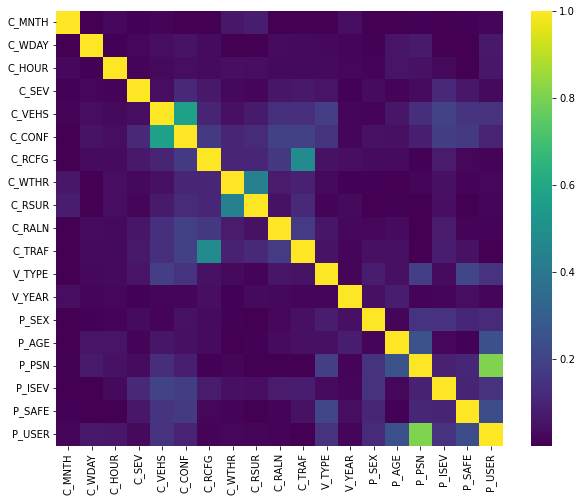

In [54]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr.abs(), cmap = 'viridis')
plt.show()

In [55]:
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr.correlation > 0.1]

,level_0,level_1,correlation
357,P_USER,P_PSN,0.806448
99,C_CONF,C_VEHS,0.569530
196,C_TRAF,C_RCFG,0.476038
159,C_RSUR,C_WTHR,0.431270
299,P_PSN,P_AGE,0.252754
356,P_USER,P_AGE,0.246080
359,P_USER,P_SAFE,0.232074
334,P_SAFE,V_TYPE,0.208211
308,P_ISEV,C_VEHS,0.196764
195,C_TRAF,C_CONF,0.194745


# Sampling variable C_SEV

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

Como ya vimos en el analisis EDA, es facilmente apreciable la gran diferencia del computo total de valores 0 y 1 en la variable objetivo. Este caso puede afectar a predecir peor los ceros y unos, por esta razon realizaremos un aumento del valor menor para compensar esa diferencia y reducir la brecha entre ambos valores.

Primeramente aislaremos la variable traget del resto del data set

In [57]:
# separamos la variable target del resto de variables
X = df_car_t.drop('C_SEV', axis=1)
Y = df_car_t.C_SEV

Realizamos un split de los vectores antes creados donde train sera la muestra completa menos el porcentaje que asignamos a xtest para testear os resultados de xtrain. Realizamos el mismo proceso para la variable target.

In [58]:
xtrain, xtest, ytrain, ytest = train_test_split( X, Y, test_size=0.2, random_state=0)

A continuación realizamos un paso muy importante comentado al principio de este apartado, el aumento de la muestra para el valor minoritario dentro de C_SEV. Para ello importamos SMOTE cuya funcion principal es aumentar los valores uno(al menos una muerte) de manera sintetica, es decir, no son valores reales para que el resultado final no se vea afectado por este desajuste.

In [59]:
sm = SMOTE(random_state = 12345, n_jobs=-1, sampling_strategy=0.3)
X_train_sampled, y_train_sampled =sm.fit_resample(xtrain, ytrain)
X_train = pd.DataFrame(X_train_sampled, columns = xtrain.columns)

Comprobamos que el size de los respectivos Xtrain e ytrain siguen siendo igual, ya que esto podría darnos problemas a la hora de aplicar los modelos

In [60]:
print(len(X_train_sampled))
print(len(xtest))
print(len(y_train_sampled))
print(len(ytest))

5992439
1172081
5992439
1172081


Finalmente, tambien realizaremos una normalización de las variables cuya funcionalidad principal es calcular la distancia o posicion del valor respecto de su minimo comprimido en un rago delimitado por su propio máximo y minimo. 

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_scaled = scaler.fit(X_train_sampled)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_sampled), columns=X_train_sampled.columns, index=X_train_sampled.index)
X_test_scaled = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns, index=xtest.index)

In [62]:
print(len(X_train_scaled))
print(len(X_test_scaled))
print(len(y_train_sampled))
print(len(ytest))

5992439
1172081
5992439
1172081


# Seleccion de variables LASSO

Modelo Lasso es un método de regresion lineal que tiene su funcion de coste con la cual trata de optimizar sus resultados, en este caso sus coeficientes. Para ello, trata de reducir los coeficientes de las variables a cero para quedarse con aquellos que son distintos de cero. Es decir, fuerza que los coeficientes tiendan a cero para que asi los de mayor coeficiente, y en ese caso los coeficientes con mayor importantcia, sobrevivan a dicha elección y los que sean iguales a cero eliminarlos. De esta manera seleccionaremos que variables utilizar para los modelos.

In [63]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.07) # jugar con el threshold
sel_lasso.fit(X_train_sampled, y_train_sampled)


SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.07)

In [64]:
sel_lasso.get_support()
selected_feat_lasso = X_train_sampled.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF',
       'V_TYPE', 'P_SEX', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER'],
      dtype='object')

In [65]:
print('total features: {}'.format((X_train_sampled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 18
selected features: 13


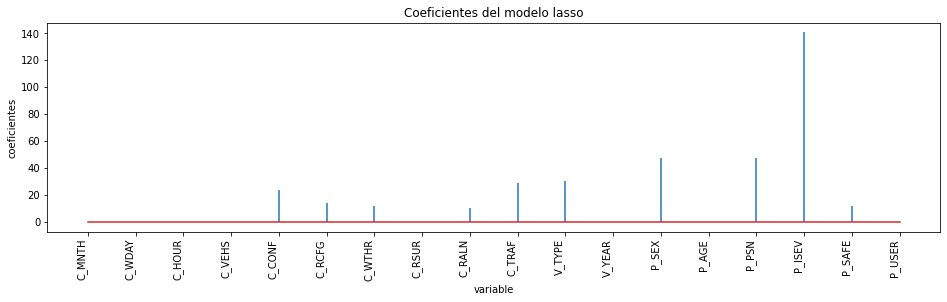

In [66]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train_sampled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

Seleccionamos las variables que según el modelo Lasso son más importantes.

In [67]:
X_train_scaled_1 = X_train_scaled[selected_feat_lasso]

In [68]:
X_train_scaled_1

,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SEX,P_PSN,P_ISEV,P_SAFE,P_USER
0,-0.438782,0.118725,1.144526,2.393207,0.715341,0.439446,0.764399,-0.361544,-1.280592,0.245548,-0.342922,-0.337972,0.574558
1,-0.015117,-0.708950,-0.889707,-0.258588,0.001593,-0.523092,-1.513514,-0.361544,0.831069,0.245548,-0.342922,-0.337972,0.574558
2,0.408548,-0.708950,1.144526,-0.802837,-0.953540,-0.523092,-1.513514,-0.361544,0.831069,0.219976,-0.342922,-0.337972,0.574558
3,-0.015117,-0.323684,-0.889707,-0.258588,0.001593,-0.523092,-0.517314,-0.361544,0.831069,-0.510375,-0.342922,-0.337972,-0.608190
4,-0.015117,-0.141013,1.144526,-0.258588,0.001593,-0.523092,0.764399,0.672261,0.831069,-0.510375,-0.352727,-0.337972,-0.608190
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5992434,0.832213,-0.591499,0.524378,-0.258588,0.001593,-0.523092,0.069963,1.295213,0.831069,-0.510375,-0.349927,-0.324236,-0.608190
5992435,-0.015117,3.483854,-0.889707,-0.258588,0.001593,-0.523092,-0.801624,-0.361544,-1.280592,-0.510375,3.401321,-0.337972,-0.608190
5992436,-0.438782,0.576900,1.144526,-0.258588,5.770779,-0.523092,0.764399,-0.361544,-1.280592,-0.510375,1.744647,4.107080,-0.608190
5992437,-0.438782,0.300553,-0.911686,-0.066573,-0.210142,-0.523092,-0.233183,1.134556,0.831069,2.354717,3.401321,0.583774,1.757306


# RANDOM FOREST

### Obtencion de parametros y entrenamiento

In [76]:
param_test = {
    'max_depth' : [2,6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini','entropy'] 
 }

gsearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(100), 
                               param_grid = param_test, scoring='roc_auc',n_jobs=-1, refit = True)

In [77]:
gsearch_RandomForest.fit(X_train_scaled_1, y_train_sampled)

/Users/javiserrat_/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 6],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='roc_auc')

In [78]:
gsearch_RandomForest.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt')

In [79]:
gsearch_RandomForest.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt'}

In [81]:
Best_RF = gsearch_RandomForest.best_estimator_
Best_RF.fit(X_train_scaled_1, y_train_sampled)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt')

In [89]:
X_test_scaled_1 = X_test_scaled[selected_feat_lasso]

In [90]:
LeadScore = Best_RF.predict_proba(X_test_scaled_1)
print(LeadScore)

[[0.9814076  0.0185924 ]
 [0.91875317 0.08124683]
 [0.86756413 0.13243587]
 ...
 [0.87481862 0.12518138]
 [0.99243424 0.00756576]
 [0.92794054 0.07205946]]


In [91]:
# Predict
pred = Best_RF.predict(X_test_scaled_1)

print(pred)

[0 0 0 ... 0 0 0]


In [92]:
accuracy_score(ytest, pred) 

0.9899418214270174

### Matriz confianza

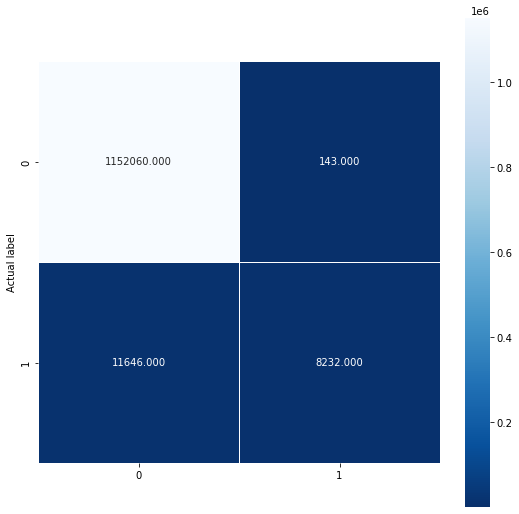

In [96]:
cm_random = confusion_matrix(ytest, pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm_random, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

In [101]:
from sklearn.metrics import plot_confusion_matrix

/Users/javiserrat_/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[1152060     143]
 [  11646    8232]]


/Users/javiserrat_/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[9.99875890e-01 1.24110074e-04]
 [5.85873830e-01 4.14126170e-01]]


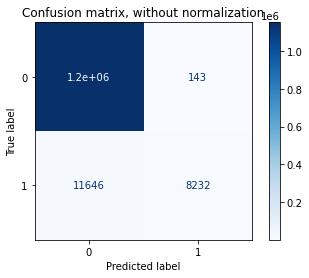

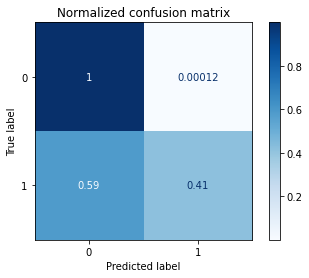

In [103]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gsearch_RandomForest, X_test_scaled_1, ytest,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### ROC Curve

In [108]:
import scikitplot as skplt

/Users/javiserrat_/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


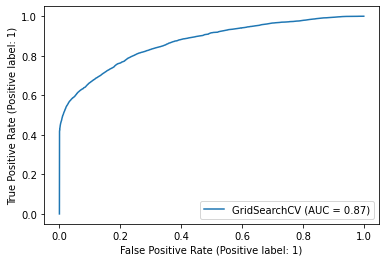

In [112]:
metrics.plot_roc_curve(gsearch_RandomForest, X_test_scaled_1, ytest)
plt.show()

In [109]:
predicted_probas = gsearch_RandomForest.predict_proba(X_test_scaled_1)

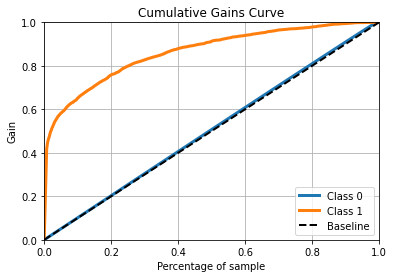

In [110]:
skplt.metrics.plot_cumulative_gain(ytest, predicted_probas)
plt.show()

### Lift Curve

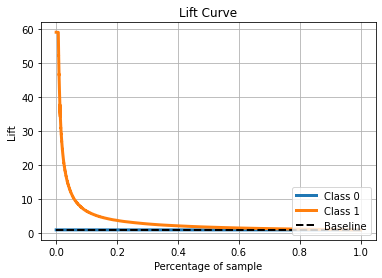

In [114]:
skplt.metrics.plot_lift_curve(ytest, predicted_probas)
plt.show()

### Histogram

Text(0, 0.5, 'Frequency')

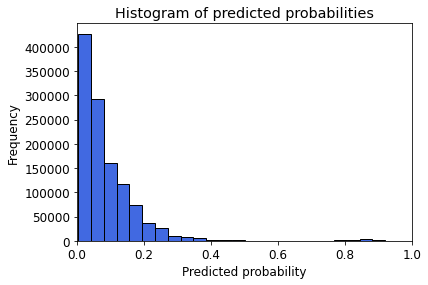

In [116]:
y_pred_prob = predicted_probas[:, 1]

plt.rcParams['font.size'] = 12
plt.hist(y_pred_prob, bins=25,facecolor='royalblue', edgecolor = 'black')
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

# Save the model 

In [120]:
model = gsearch_RandomForest
filename = 'RF.sav'
pickle.dump(model, open(filename, 'wb'))

In [123]:
filename3 = 'RF.sav'
RF = pickle.load(open(filename3, 'rb'))
pred = RF.predict(X_test_scaled_1)
accuracy_score(ytest, pred) 

0.9899418214270174